In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
from gpytorch import means, kernels
from gpytorch.utils.grid import create_data_from_grid
import xarray as xr
import tqdm
import seaborn as sns
from sklearn.metrics import pairwise_distances

base_dir = os.path.join(os.getcwd(), '../..')
sys.path.append(base_dir)

from src.models import VariationalCMEProcess
from src.likelihoods import CMEProcessLikelihood

standardize = lambda x: (x - x.mean()) / x.std()

### Load Cloud Top Temperatur and Cloud Top Pressure fields

HR shape : (354, 717) | (118.0, 239.0) bags
LR shape : (118, 239) | (118, 239) bags


/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


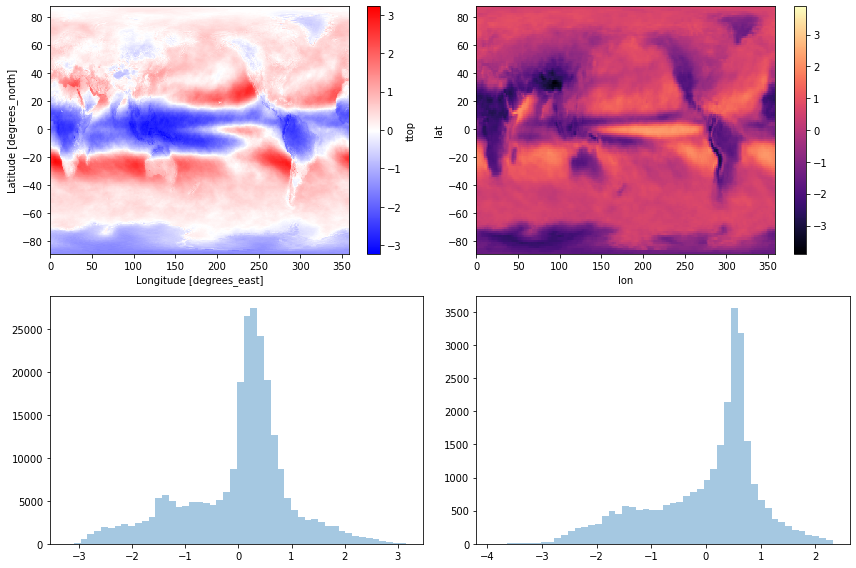

In [2]:
ttop = xr.open_dataarray('./data/mean_ttop_1950_lat354_lon717.nc')
ptop = xr.open_dataarray('./data/mean_pctisccp_1950_lat118_lon239.nc')

bs = 3 # blocks size

ttop, ptop = standardize(ttop), standardize(ptop)
n_bags = ptop.shape[0] * ptop.shape[1]
    
print(f"HR shape : {ttop.shape} | {(ttop.shape[0] / bs, ttop.shape[1] / bs)} bags")
print(f"LR shape : {ptop.shape} | {ptop.shape} bags")

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ttop.plot(ax=ax[0, 0], cmap='bwr')
ptop.plot(ax=ax[0, 1], cmap='magma')
sns.distplot(ttop.values.flatten(), kde=False, ax=ax[1, 0])
sns.distplot(ptop.values.flatten(), kde=False, ax=ax[1, 1])

plt.tight_layout()
plt.show()

### Create dataset

In [3]:
# Create training grid
lat = torch.from_numpy(ttop.lat.values)
lon = torch.from_numpy(ttop.lon.values)
lat, lon = standardize(lat), standardize(lon)
grid = torch.stack(torch.meshgrid(lat, lon), dim=-1).float()
grid = torch.cat([grid, torch.from_numpy(ttop.values).unsqueeze(-1)], dim=-1)

def make_grid_dataset(grid, block_size):
    blocks = torch.cat([torch.stack(x.split(block_size, dim=1)) 
                        for x in grid.split(block_size)]).view(-1, block_size**2, 3)
    bags = blocks.mean(dim=1)
    extended_bags = bags.unsqueeze(1).repeat((1, block_size**2, 1))
    return blocks, bags, extended_bags

individuals_tensors, bags_tensor, extended_bags_tensor = make_grid_dataset(grid, bs)
aggregate_targets_tensor = torch.from_numpy(ptop.values.flatten()).float()
inducing_points = bags_tensor[::80]

print("Individuals : ", individuals_tensors.shape)
print("Bags values : ", bags_tensor.shape)
print("Aggregate targets : ", aggregate_targets_tensor.shape)
print("Extended bags values : ", extended_bags_tensor.shape)
print("Inducing points : ", inducing_points.shape)

def batch_iterator(batch_size):
    rdm_indices = torch.randperm(n_bags)
    for idx in rdm_indices.split(batch_size):
        x = individuals_tensors[idx].reshape(-1, 3)
        y = bags_tensor[idx]
        extended_y = extended_bags_tensor[idx].reshape(-1, 3)
        z = aggregate_targets_tensor[idx]
        yield x, y, extended_y, z

Individuals :  torch.Size([28202, 9, 3])
Bags values :  torch.Size([28202, 3])
Aggregate targets :  torch.Size([28202])
Extended bags values :  torch.Size([28202, 9, 3])
Inducing points :  torch.Size([353, 3])


### Compute median distance between feature for lengthscale intializations

In [4]:
foo = grid.reshape(-1, 3)
rdm_idx = torch.randperm(len(foo))[:5000]

lat_scale = np.median(pairwise_distances(foo[rdm_idx, 0].reshape(-1, 1).numpy()))
lon_scale = np.median(pairwise_distances(foo[rdm_idx, 1].reshape(-1, 1).numpy()))
ttop_scale = np.median(pairwise_distances(foo[rdm_idx, 2].reshape(-1, 1).numpy()))

print("Latitude lengthscale : ", lat_scale)
print("Longitude lengthscale : ", lon_scale)
print("Temperature lengthscale : ", ttop_scale)

Latitude lengthscale :  1.0064986
Longitude lengthscale :  1.0138837
Temperature lengthscale :  0.83162284


## Define covariance modules

In [77]:
inv_softplus = lambda x, n: torch.log(torch.exp(x * torch.ones(n)) - 1)

# Define mean and covariance modules
individuals_mean = means.ZeroMean()

# Define individuals kernel
base_indiv_spatial_kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0, 1])
base_indiv_spatial_kernel.initialize(raw_lengthscale=inv_softplus(x=1, n=2))

base_indiv_ttop_kernel = kernels.RBFKernel(active_dims=[2])
base_indiv_ttop_kernel.initialize(raw_lengthscale=inv_softplus(x=0.8, n=1))

individuals_spatial_kernel = kernels.ScaleKernel(base_indiv_spatial_kernel)
individuals_ttop_kernel = kernels.ScaleKernel(base_indiv_ttop_kernel)
individuals_kernel = individuals_spatial_kernel + individuals_ttop_kernel

# Define bag kernel - basically same
base_bag_spatial_kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0, 1])
base_bag_spatial_kernel.initialize(raw_lengthscale=inv_softplus(x=1, n=2))

base_bag_ttop_kernel = kernels.RBFKernel(active_dims=[2])
base_bag_ttop_kernel.initialize(raw_lengthscale=inv_softplus(x=0.8, n=1))

bag_spatial_kernel = kernels.ScaleKernel(base_bag_spatial_kernel)
bag_ttop_kernel = kernels.ScaleKernel(base_bag_ttop_kernel)
bag_kernel = bag_spatial_kernel + bag_ttop_kernel

### Create model

In [78]:
# Instantiate model
model = VariationalCMEProcess(inducing_points=inducing_points,
                              individuals_mean=individuals_mean, 
                              individuals_kernel=individuals_kernel,
                              bag_kernel=bag_kernel,
                              lbda=1e-6)

likelihood = CMEProcessLikelihood()

### Define stitching function for output visualization

In [5]:
def reconstruct_full_img(gs, grid):
    model.eval()
    likelihood.eval()
    row_wise_pred = []
    for i in tqdm.tqdm(range(0, grid.shape[0], gs)):
        col_wise_pred = []
        for j in range(0, grid.shape[1], gs):
            x_test = grid[i:i+gs, j:j+gs]
            block_size = x_test.shape[:-1]
            with torch.no_grad():
                individuals_posterior = model(x_test.reshape(-1, 3))
            col_wise_pred.append(individuals_posterior.mean.reshape(*block_size))
        row_tensor = torch.cat(col_wise_pred, dim=1)
        row_wise_pred.append(row_tensor)
    full_tensor = torch.cat(row_wise_pred, dim=0)
    model.train()
    likelihood.train()
    return full_tensor

def save_img(epoch, tensor):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    im = ax.imshow(tensor, cmap='magma')
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.savefig(f"ptop_epoch_{epoch}.png")
    plt.close()

## Fit MLE of hyperparameters

In [6]:
torch.random.manual_seed(52)
epochs = 8
batch_size = 256

model.train()
likelihood.train()

parameters = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params=parameters, lr=1e-3)

elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(aggregate_targets_tensor))

epochs_iter = tqdm.notebook.tqdm(range(4, epochs), desc="Epoch")
for epoch in epochs_iter:
    batch_iter = tqdm.notebook.tqdm(batch_iterator(batch_size), desc="Batch", 
                                    total=len(bags_tensor) // batch_size)
    for x, y, extended_y, z in batch_iter:
        optimizer.zero_grad()
        q = model(x)
        buffer = model.get_elbo_computation_parameters(bags_values=y,
                                                       extended_bags_values=extended_y)
        root_inv_extended_bags_covar, bags_to_extended_bags_covar = buffer
        loss = -elbo(variational_dist_f=q, 
                     target=z,
                     root_inv_extended_bags_covar=root_inv_extended_bags_covar,
                     bags_to_extended_bags_covar=bags_to_extended_bags_covar)

        loss.backward()
        optimizer.step()
        lengthscales = model.individuals_kernel.kernels[0].base_kernel.lengthscale[0].detach()
        lt = model.individuals_kernel.kernels[1].base_kernel.lengthscale[0].detach()
        batch_iter.set_postfix(loss=loss.item(),
                               n=likelihood.noise.item(),
                               l1=lengthscales[0].item(),
                               l2=lengthscales[1].item(),
                               lt=lt[0].item())
    full_tensor = reconstruct_full_img(gs=10, grid=grid)
    save_img(int(epoch), full_tensor.numpy()[::-1])